In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import ADASYN
import warnings
from model_functions import *

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(".\\DATA\\Telco-Customer-Churn.csv")

## 1. Training model on imbalanced dataset

### Train Test Split

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
X = df.drop(["Churn", "customerID"], axis=1)
X = pd.get_dummies(X)

In [6]:
y = df["Churn"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

### GridSearch Cross Validation

In [8]:
n_estimators = [10, 20, 50, 100]
max_features = ["sqrt", "log2", None]
learning_rate_ada = [0.05, 0.5, 1.0, 1.5, 3]
learning_rate_gradient = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
max_depth = [2, 3, 4, 5, 6, 7]

In [9]:
param_grid_random = {"n_estimators": n_estimators, "max_features": max_features}

param_grid_ada = {"n_estimators": n_estimators, "learning_rate": learning_rate_ada}

param_grid_gradient = {
    "learning_rate": learning_rate_gradient,
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "max_features": max_features,
}

In [10]:
rfc = RandomForestClassifier()

In [11]:
abc = AdaBoostClassifier()

In [12]:
gbc = GradientBoostingClassifier()

In [55]:
grid_rfc = fitter(rfc, param_grid_random, X_train, y_train)

In [56]:
grid_rfc

RandomForestClassifier()

In [64]:
grid_abc = fitter(abc, param_grid_ada, X_train, y_train)

In [65]:
grid_abc

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)

In [66]:
grid_gbc = fitter(gbc, param_grid_gradient, X_train, y_train)

In [67]:
grid_gbc

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features='sqrt',
                           n_estimators=20)

RandomForestClassifier()
              precision    recall  f1-score   support

          No       0.82      0.89      0.86       517
         Yes       0.61      0.47      0.53       187

    accuracy                           0.78       704
   macro avg       0.72      0.68      0.69       704
weighted avg       0.77      0.78      0.77       704

roc_auc_score = 0.68


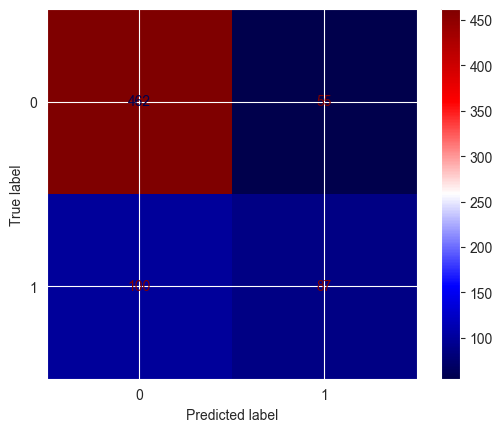

In [68]:
evaluate(grid_rfc, X_test, y_test)

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)
              precision    recall  f1-score   support

          No       0.83      0.88      0.85       517
         Yes       0.59      0.49      0.53       187

    accuracy                           0.77       704
   macro avg       0.71      0.68      0.69       704
weighted avg       0.76      0.77      0.77       704

roc_auc_score = 0.68


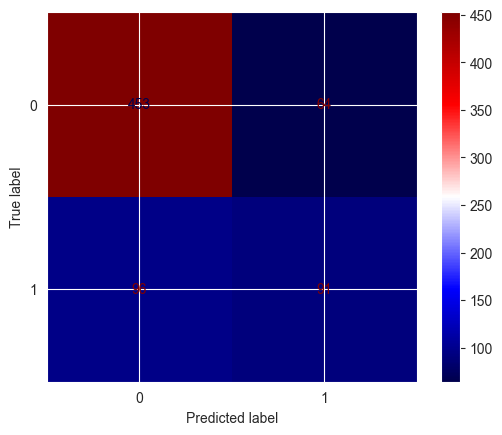

In [70]:
evaluate(grid_abc, X_test, y_test)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features='sqrt',
                           n_estimators=20)
              precision    recall  f1-score   support

          No       0.84      0.87      0.85       517
         Yes       0.60      0.53      0.56       187

    accuracy                           0.78       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.77      0.78      0.78       704

roc_auc_score = 0.7


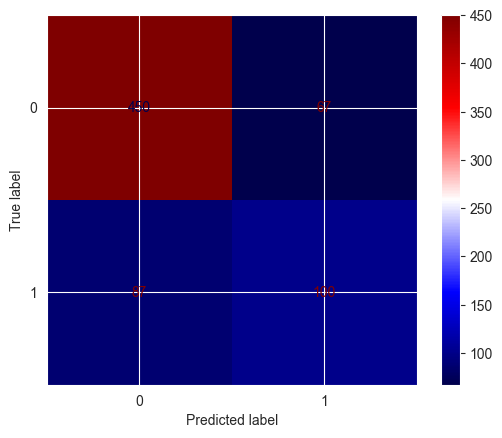

In [71]:
evaluate(grid_gbc, X_test, y_test)

### Support vector classifier adjustment

In [29]:
svc = SVC()

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
param_grid_svc = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 1.1, 10, 100],
    "gamma": ["scale", "auto"],
    "kernel": ["linear", "rbf"],
    "class_weight": [None, "balanced"],
}

In [ ]:
grid_svc = fitter(svc, param_grid_svc, X_train_scaled, y_train)

In [ ]:
grid_svc

In [ ]:
evaluate(grid_svc, X_test_scaled, y_test)

GradientBoostingClassifier performed better

## 2. ADASYN 

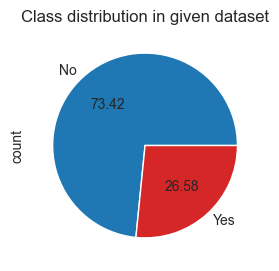

In [35]:
plt.figure(figsize=(3, 3))
colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[3]]
df["Churn"].value_counts().plot.pie(autopct="%.2f", colors=colors)
plt.title("Class distribution in given dataset");

Pretty imbalanced dataset

In [74]:
oversample = ADASYN()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

In [75]:
grid_gbc_balanced = fitter(gbc, param_grid_gradient, X_train_balanced, y_train_balanced)

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, max_features='sqrt')
              precision    recall  f1-score   support

          No       0.84      0.84      0.84       517
         Yes       0.56      0.57      0.57       187

    accuracy                           0.77       704
   macro avg       0.70      0.71      0.70       704
weighted avg       0.77      0.77      0.77       704

roc_auc_score = 0.71


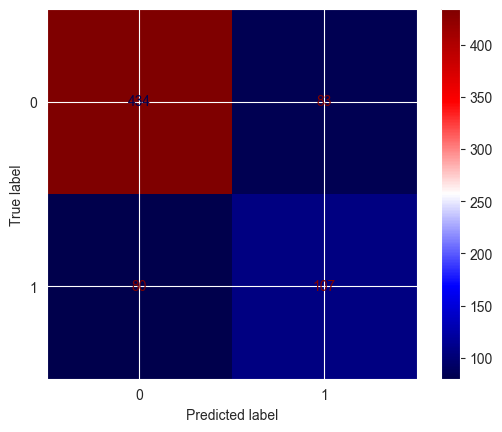

In [76]:
evaluate(grid_gbc_balanced, X_test, y_test)